In [1]:
import xarray as xr
import csv
import pandas as pd
import numpy as np
import os
import pickle as pkl
from datetime import datetime, date, timedelta
import sys
import matplotlib.pyplot as plt
import netCDF4 as nc
import glob
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from numpy import trapz
import pickle


In [2]:
# Define parameters
# define start and end years
start_year = 2011 # 2009
end_year = 2015 # 2018

max_depth_index_sel = 22


In [13]:
# List all files across three basins
folder_tags = ['WPacific','California', 'Florida']
HYCOM_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/DATA/HYCOM_near_TC_53x_pkl_postproc_BASIN/'
files = []

for i in np.arange(len(folder_tags)):

    HYCOM_dir_current = HYCOM_dir.replace('BASIN', str(folder_tags[i])) 
    files_in_dir = [j for j in sorted(glob.glob(HYCOM_dir_current + '*.pkl'))]
    files = files + files_in_dir 


In [14]:
# Load first to initialize variables that will store them all
new_dict = pkl.load(open(files[1], "rb"))
temperature_abs_all = np.zeros((112,new_dict.temperature_abs.shape[1],len(files)))
salinity_abs_all = np.zeros((112,new_dict.salinity_abs.shape[1],len(files)))
temperature_anom_all = np.zeros((112,new_dict.temperature_anom.shape[1],len(files)))
salinity_anom_all = np.zeros((112,new_dict.salinity_anom.shape[1],len(files)))
temperature_abs_minus2_all = np.zeros((112,new_dict.temperature_abs_minus2.shape[1],len(files)))
salinity_abs_minus2_all = np.zeros((112,new_dict.salinity_abs_minus2.shape[1],len(files)))
integral_precip_all = np.zeros(len(files))

# Loop across events and store variables
for i in np.arange(len(files)):
    
    # Open file
    new_dict = pkl.load(open(files[i], "rb"))
    
    # Store variables 
    # note: some events have 113 rows and not 112
    # This is because the selection of HYCOM data to keep was +- 7 days from the event center (datetime from forcing)
    # Forcing had data points every hour, while HYCOM every 3 hours
    # So in some case 1 extra row was kept (when the datetime from forcing was one of the 3-hour periods with HYCOM data)
    temperature_abs_all[:,:,i] = new_dict.temperature_abs.values[0:112,:]
    salinity_abs_all[:,:,i] = new_dict.salinity_abs.values[0:112,:]
    temperature_anom_all[:,:,i] = new_dict.temperature_anom.values[0:112,:]
    salinity_anom_all[:,:,i] = new_dict.salinity_anom.values[0:112,:]
    temperature_abs_minus2_all[:,:,i] = new_dict.temperature_abs_minus2.values[0:112,:]
    salinity_abs_minus2_all[:,:,i] = new_dict.salinity_abs_minus2.values[0:112,:]
    integral_precip_all[i] = new_dict.integral_precip
 
# Calculate average across all events    
temperature_abs_mean_all = np.nanmean(temperature_abs_all, axis = 2)
salinity_abs_mean_all = np.nanmean(salinity_abs_all, axis = 2)
temperature_anom_mean_all = np.nanmean(temperature_anom_all, axis = 2)
salinity_anom_mean_all = np.nanmean(salinity_anom_all, axis = 2)
temperature_abs_minus2_mean_all = np.nanmean(temperature_abs_minus2_all, axis = 2)
salinity_abs_minus2_mean_all = np.nanmean(salinity_abs_minus2_all, axis = 2)

# Find depth where profile is increasing vs decreasing
dz_increasing = np.zeros(salinity_abs_all.shape[2])
dz_decreasing = np.zeros(salinity_abs_all.shape[2])
dz_dsame = np.zeros(salinity_abs_all.shape[2])
dz = np.array([2,2,2,2,2,2.5,4,5,5,5,5,5,5,7.5,10,10,10,10,17.5,25,37.5,50,50,50,50,75,50]) # spessore per ogni livello di pressione
for i in np.arange(0,salinity_abs_all.shape[2]):
    dz_increasing[i] = sum(dz[(salinity_abs_all[0,1:,i]-salinity_abs_all[0,0,i])>0])
    dz_decreasing[i] = sum(dz[(salinity_abs_all[0,1:,i]-salinity_abs_all[0,0,i])<0])
    dz_dsame[i] = sum(dz[(salinity_abs_all[0,1:,i]-salinity_abs_all[0,0,i])==0])

# # Calculate averages, increasing vs decreasing
# temperature_abs_mean_incr = np.nanmean(temperature_abs_all[:,:,dz_increasing > dz_decreasing], axis = 2)
# salinity_abs_mean_incr = np.nanmean(salinity_abs_all[:,:,dz_increasing > dz_decreasing], axis = 2)
# temperature_anom_mean_incr = np.nanmean(temperature_anom_all[:,:,dz_increasing > dz_decreasing], axis = 2)
# salinity_anom_mean_incr = np.nanmean(salinity_anom_all[:,:,dz_increasing > dz_decreasing], axis = 2)
# temperature_abs_minus2_mean_incr = np.nanmean(temperature_abs_minus2_all[:,:,dz_increasing > dz_decreasing], axis = 2)
# salinity_abs_minus2_mean_incr = np.nanmean(salinity_abs_minus2_all[:,:,dz_increasing > dz_decreasing], axis = 2)

# temperature_abs_mean_decr = np.nanmean(temperature_abs_all[:,:,dz_increasing < dz_decreasing], axis = 2)
# salinity_abs_mean_decr = np.nanmean(salinity_abs_all[:,:,dz_increasing < dz_decreasing], axis = 2)
# temperature_anom_mean_decr = np.nanmean(temperature_anom_all[:,:,dz_increasing < dz_decreasing], axis = 2)
# salinity_anom_mean_decr = np.nanmean(salinity_anom_all[:,:,dz_increasing < dz_decreasing], axis = 2)
# temperature_abs_minus2_mean_decr = np.nanmean(temperature_abs_minus2_all[:,:,dz_increasing < dz_decreasing], axis = 2)
# salinity_abs_minus2_mean_decr = np.nanmean(salinity_abs_minus2_all[:,:,dz_increasing < dz_decreasing], axis = 2)

# # Calculate averages, lot vs little precipitation
# temperature_abs_mean_little_rain = np.nanmean(temperature_abs_all[:,:,integral_precip_all < np.nanmean(integral_precip_all)], axis = 2)
# salinity_abs_mean_little_rain = np.nanmean(salinity_abs_all[:,:,integral_precip_all < np.nanmean(integral_precip_all)], axis = 2)
# temperature_anom_mean_little_rain = np.nanmean(temperature_anom_all[:,:,integral_precip_all < np.nanmean(integral_precip_all)], axis = 2)
# salinity_anom_mean_little_rain = np.nanmean(salinity_anom_all[:,:,integral_precip_all < np.nanmean(integral_precip_all)], axis = 2)
# temperature_abs_minus2_mean_little_rain = np.nanmean(temperature_abs_minus2_all[:,:,integral_precip_all < np.nanmean(integral_precip_all)], axis = 2)
# salinity_abs_minus2_mean_little_rain = np.nanmean(salinity_abs_minus2_all[:,:,integral_precip_all < np.nanmean(integral_precip_all)], axis = 2)

# temperature_abs_mean_lot_rain = np.nanmean(temperature_abs_all[:,:,integral_precip_all > np.nanmean(integral_precip_all)], axis = 2)
# salinity_abs_mean_lot_rain = np.nanmean(salinity_abs_all[:,:,integral_precip_all > np.nanmean(integral_precip_all)], axis = 2)
# temperature_anom_mean_lot_rain = np.nanmean(temperature_anom_all[:,:,integral_precip_all > np.nanmean(integral_precip_all)], axis = 2)
# salinity_anom_mean_lot_rain = np.nanmean(salinity_anom_all[:,:,integral_precip_all > np.nanmean(integral_precip_all)], axis = 2)
# temperature_abs_minus2_mean_lot_rain = np.nanmean(temperature_abs_minus2_all[:,:,integral_precip_all > np.nanmean(integral_precip_all)], axis = 2)
# salinity_abs_minus2_mean_lot_rain = np.nanmean(salinity_abs_minus2_all[:,:,integral_precip_all > np.nanmean(integral_precip_all)], axis = 2)



(array([1., 1., 2., 2., 2., 0., 0., 0., 0., 1.]),
 array([0.04133351, 0.05576661, 0.07019971, 0.08463281, 0.0990659 ,
        0.113499  , 0.1279321 , 0.1423652 , 0.1567983 , 0.1712314 ,
        0.1856645 ]),
 <BarContainer object of 10 artists>)

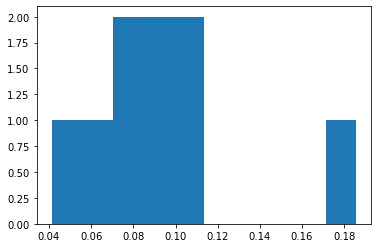

In [15]:
plt.hist(integral_precip_all)
# integral_precip_all.mean()
# add line where the mean

In [16]:
def create_composite(data, mask):
    data_composite = np.nanmean(data[:,:,mask], axis = 2)
    print('Number of events in this case = ', str(sum(mask)))
    data_composite_std = np.std(data[:,:,mask], axis = 2) # check if divides by n-1
    return(data_composite, data_composite_std)


def name_composite(str_data, str_mask):
    str_composite = str_data[0:-3] 
    if str_mask=='dz_increasing > dz_decreasing':
        tag_str_mask = 'mean_incr' # check to change mean with comp
    elif str_mask=='dz_increasing < dz_decreasing':
        tag_str_mask = 'mean_decr'
    elif str_mask=='integral_precip_all < np.nanmean(integral_precip_all)':
        tag_str_mask = 'mean_little_rain'
    elif str_mask=='integral_precip_all > np.nanmean(integral_precip_all)':
        tag_str_mask = 'mean_lot_rain'
    elif str_mask=='np.logical_and(dz_increasing > dz_decreasing, integral_precip_all < 2*np.nanmean(integral_precip_all))':
        tag_str_mask = 'mean_incr_little_rain'
    elif str_mask=='np.logical_and(dz_increasing < dz_decreasing, integral_precip_all < 2*np.nanmean(integral_precip_all))':
        tag_str_mask = 'mean_decr_little_rain'
    elif str_mask=='np.logical_and(dz_increasing > dz_decreasing, integral_precip_all > 2*np.nanmean(integral_precip_all))':
        tag_str_mask = 'mean_incr_lot_rain'
    elif str_mask=='np.logical_and(dz_increasing < dz_decreasing, integral_precip_all > 2*np.nanmean(integral_precip_all))':
        tag_str_mask = 'mean_decr_lot_rain'
    elif str_mask=='dz_increasing==dz_increasing':
        tag_str_mask = 'ALL'
    else:
        print('Define new case!!')
    return(str_composite + tag_str_mask)
    



In [17]:
data = ['temperature_abs_all', 'salinity_abs_all', 'temperature_anom_all', 'salinity_anom_all', \
        'temperature_abs_minus2_all', 'salinity_abs_minus2_all']
data_mask = ['dz_increasing > dz_decreasing', 'dz_increasing < dz_decreasing', \
             'integral_precip_all < np.nanmean(integral_precip_all)',\
            'integral_precip_all > np.nanmean(integral_precip_all)', \
            'np.logical_and(dz_increasing < dz_decreasing, integral_precip_all < 2*np.nanmean(integral_precip_all))',\
            'np.logical_and(dz_increasing > dz_decreasing, integral_precip_all < 2*np.nanmean(integral_precip_all))',\
            'np.logical_and(dz_increasing < dz_decreasing, integral_precip_all > 2*np.nanmean(integral_precip_all))',\
            'np.logical_and(dz_increasing > dz_decreasing, integral_precip_all > 2*np.nanmean(integral_precip_all))',\
            'dz_increasing==dz_increasing']


In [18]:

for idata in data:
    for imask in data_mask:
        bfr_d = eval(idata)
        bfr_mask = eval(imask)
        print(name_composite(idata,imask))
        bfr = create_composite(bfr_d, bfr_mask)
        
        exec(name_composite(idata, imask) + ' = bfr[0]')
        exec(name_composite(idata, imask) + '_std = bfr[1]')

temperature_abs_mean_incr
Number of events in this case =  7
temperature_abs_mean_decr
Number of events in this case =  2
temperature_abs_mean_little_rain
Number of events in this case =  6
temperature_abs_mean_lot_rain
Number of events in this case =  3
temperature_abs_mean_decr_little_rain
Number of events in this case =  2
temperature_abs_mean_incr_little_rain
Number of events in this case =  7
temperature_abs_mean_decr_lot_rain
Number of events in this case =  0
temperature_abs_mean_incr_lot_rain
Number of events in this case =  0
temperature_abs_ALL
Number of events in this case =  9
salinity_abs_mean_incr
Number of events in this case =  7
salinity_abs_mean_decr
Number of events in this case =  2
salinity_abs_mean_little_rain
Number of events in this case =  6
salinity_abs_mean_lot_rain
Number of events in this case =  3
salinity_abs_mean_decr_little_rain
Number of events in this case =  2
salinity_abs_mean_incr_little_rain
Number of events in this case =  7
salinity_abs_mean_dec

/var/folders/yx/vl8ptm8n76s45fyq76jyjj280000gp/T/ipykernel_92944/2619076612.py:2: RuntimeWarning: Mean of empty slice
  data_composite = np.nanmean(data[:,:,mask], axis = 2)


In [ ]:
f, (a2, a3) = plt.subplots(2, 1, figsize = (12,12))

# HYCOM TEMPERATURE anomalies
im2 = a2.pcolor(time_plot,new_dict.depth.values,salinity_abs_minus2_mean_incr_std.transpose(), vmin=-.25, vmax=.25, cmap="RdBu_r")
a2.set_ylabel('Depth (m)', fontsize = 12)
a2.set_ylim([new_dict.depth[0], new_dict.depth[max_depth_index_sel]]) # select the first 200 meters
a2.invert_yaxis()
# Colorbar for temperature
divider = make_axes_locatable(a2)
cax = divider.append_axes('right', size='2%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='vertical')
a2.set_title('salinity_abs_minus2_mean_incr_lot_rain', fontsize = 14)

im3 = a3.pcolor(time_plot,new_dict.depth.values,salinity_abs_minus2_mean_incr.transpose(), vmin=-.1, vmax=.1, cmap="RdBu_r")
a3.set_ylabel('Depth (m)', fontsize = 12)
a3.set_ylim([new_dict.depth[0], new_dict.depth[max_depth_index_sel]]) # select the first 200 meters
a3.invert_yaxis()
# Colorbar for temperature
divider = make_axes_locatable(a3)
cax = divider.append_axes('right', size='2%', pad=0.05)
f.colorbar(im3, cax=cax, orientation='vertical')
a3.set_title('salinity_abs_minus2_mean_incr_little_rain', fontsize = 14)


In [ ]:
im3 = plt.pcolor(time_plot,new_dict.depth.values,salinity_abs_minus2_mean_incr_little_rain.transpose(), vmin=-.1, vmax=.1, cmap="RdBu_r")
a3.invert_yaxis()
f.colorbar(im3, orientation='vertical')


In [ ]:
# How many events?

print('Number of increasing events: ', sum(dz_increasing > dz_decreasing))
print('Number of decreasing events: ', sum(dz_increasing < dz_decreasing))
print('Total number of events: ', len(files))


In [ ]:
# Create datetime vector for plot (every 3 hours, from -7 to +7 days)
time_plot = np.arange(-7,7,1/8)

In [ ]:
#_______________
# PLOTS
tags = ['incr', 'decr', 'little_rain', 'lot_rain']

for tag in tags:

    # ______________
    # Make plot # 1 - anomalies
    f, (a2, a3) = plt.subplots(2, 1, figsize = (12,12))

    # HYCOM TEMPERATURE anomalies
    norm = mcolors.TwoSlopeNorm(vmin=eval("temperature_anom_mean_" + tag).min(), vmax = eval("temperature_anom_mean_" + tag).max(), vcenter=0)
    im2 = a2.contourf(time_plot,new_dict.depth.values,eval("temperature_anom_mean_" + tag).transpose(), levels = 20, cmap="RdBu_r", norm=norm)
    a2.set_ylabel('Depth (m)', fontsize = 12)
    a2.set_ylim([new_dict.depth[0], new_dict.depth[max_depth_index_sel]]) # select the first 200 meters
    a2.invert_yaxis()
    a2.axvline(x=0, linestyle = '--', c = 'k', linewidth = 1)
    # Colorbar for temperature
    divider = make_axes_locatable(a2)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    f.colorbar(im2, cax=cax, orientation='vertical')
    a2.set_title(f'HYCOM TEMPERATURE anomaly (deg C)', fontsize = 14)

    # HYCOM SALINITY anomalies
    norm = mcolors.TwoSlopeNorm(vmin=eval("salinity_anom_mean_" + tag).min(), vmax = eval("salinity_anom_mean_" + tag).max(), vcenter=0)
    im3 = a3.contourf(time_plot,new_dict.depth.values,eval("salinity_anom_mean_" + tag).transpose(), levels = 20, cmap="RdBu_r", norm=norm)
    a3.set_xlabel('Days from hurricane event center', fontsize = 12)
    a3.set_ylabel('Depth (m)', fontsize = 12)
    a3.set_ylim([new_dict.depth[0], new_dict.depth[max_depth_index_sel]]) # select the first 200 meters
    a3.invert_yaxis()
    a3.axvline(x=0, linestyle = '--', c = 'k', linewidth = 1)
    # Colorbar for temperature
    divider = make_axes_locatable(a3)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    f.colorbar(im3, cax=cax, orientation='vertical')
    a3.set_title(f'HYCOM SALINITY anomaly (psu)', fontsize = 14)

    a2.xaxis.get_label().set_fontsize(12)
    a3.xaxis.get_label().set_fontsize(12)
    a2.yaxis.get_label().set_fontsize(12)
    a3.yaxis.get_label().set_fontsize(12)
    a2.tick_params(axis='y', labelsize=12)
    a3.tick_params(axis='y', labelsize=12)

    f.tight_layout()
    f.savefig('./PLOTS_composite/' + 'ALL_' + tag + '.pdf', dpi = 300)
    # ______________

    # ______________
    # Make plot # 2 - absolute values
    f, (a0, a1) = plt.subplots(2, 1, figsize = (12,12), gridspec_kw={'height_ratios': [2, 2]})

    # Temperature
    im0 = a0.contourf(time_plot,new_dict.depth,eval("temperature_abs_mean_" + tag).transpose(), levels = 20)
    a0.set_ylabel('Depth (m)', fontsize = 12)
    a0.tick_params(axis='y', labelsize=12)
    a0.tick_params(axis='x', labelsize=12)
    a0.set_ylim([new_dict.depth[0], new_dict.depth[max_depth_index_sel]]) # select the first 200 meters
    a0.invert_yaxis()
    a0.axvline(x=0, linestyle = '--', c = 'k', linewidth = 1)
    divider = make_axes_locatable(a0)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    f.colorbar(im0, cax=cax, orientation='vertical')
    a0.set_title(f'HYCOM absolute TEMPERATURE (deg C)', fontsize = 14)

    # Salinity
    im1 = a1.contourf(time_plot,new_dict.depth,eval("salinity_abs_mean_" + tag).transpose(), levels = 20)
    # a1.contour(new_dict.time.values,new_dict.depth.values,new_dict.temperature.values.transpose(), levels = 20, linewidths=.5, colors='black')
    a1.set_xlabel('Days from hurricane event center', fontsize = 12)
    a1.set_ylabel('Depth (m)', fontsize = 12)
    a1.tick_params(axis='y', labelsize=12)
    a1.tick_params(axis='x', labelsize=12)
    a1.set_ylim([new_dict.depth[0], new_dict.depth[max_depth_index_sel]]) # select the first 200 meters
    a1.invert_yaxis()
    a1.axvline(x=0, linestyle = '--', c = 'k', linewidth = 1)
    divider = make_axes_locatable(a1)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    f.colorbar(im1, cax=cax, orientation='vertical')
    a1.set_title(f'HYCOM absolute SALINITY (psu)', fontsize = 14)

    f.tight_layout()
    f.savefig('./PLOTS_composite/' + 'ALL_' + tag + '_abs.pdf', dpi = 300)
    # ______________


    # ______________
    # Make plot # 3 - absolute values relative to day -2
    f, (a0, a1) = plt.subplots(2, 1, figsize = (12,12), gridspec_kw={'height_ratios': [2, 2]})

    # Temperature
    norm = mcolors.TwoSlopeNorm(vmin=eval("temperature_abs_minus2_mean_" + tag).min(), vmax = eval("temperature_abs_minus2_mean_" + tag).max(), vcenter=0)
    im0 = a0.contourf(time_plot,new_dict.depth,eval("temperature_abs_minus2_mean_" + tag).transpose(), levels = 20, cmap="RdBu_r", norm=norm)
    a0.axvline(x=0, linestyle = '--', c = 'k', linewidth = 1)
    a0.set_ylabel('Depth (m)', fontsize = 12)
    a0.tick_params(axis='y', labelsize=12)
    a0.tick_params(axis='x', labelsize=12)
    a0.set_xlim([-2,+7])
    a0.set_ylim([new_dict.depth[0], new_dict.depth[max_depth_index_sel]]) # select the first 200 meters
    a0.invert_yaxis()
    divider = make_axes_locatable(a0)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    f.colorbar(im0, cax=cax, orientation='vertical')
    a0.set_title(f'HYCOM absolute TEMPERATURE change from day -2 (deg C)', fontsize = 14)

    # Salinity
    norm = mcolors.TwoSlopeNorm(vmin=eval("salinity_abs_minus2_mean_" + tag).min(), vmax = eval("salinity_abs_minus2_mean_" + tag).max(), vcenter=0)
    im1 = a1.contourf(time_plot,new_dict.depth,eval("salinity_abs_minus2_mean_" + tag).transpose(), levels = 20, cmap="RdBu_r", norm=norm)
    a1.axvline(x=0, linestyle = '--', c = 'k', linewidth = 1)
    a1.set_xlabel('Days from hurricane event center', fontsize = 12)
    a1.set_ylabel('Depth (m)', fontsize = 12)
    a1.tick_params(axis='y', labelsize=12)
    a1.tick_params(axis='x', labelsize=12)
    a1.set_ylim([new_dict.depth[0], new_dict.depth[max_depth_index_sel]]) # select the first 200 meters
    a1.set_xlim([-2,+7])
    a1.invert_yaxis()
    divider = make_axes_locatable(a1)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    f.colorbar(im1, cax=cax, orientation='vertical')
    a1.set_title(f'HYCOM absolute SALINITY change from day -2 (psu)', fontsize = 14)

    f.tight_layout()
    f.savefig('./PLOTS_composite/' + 'ALL_' + tag+ '_abs_minus2.pdf', dpi = 300)
    # ______________

